# Importing Libraries

In [133]:
import plotly.offline as pox
import plotly.graph_objs as go
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, mean_squared_error
import yfinance as yf
import datetime
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from alpha_vantage.timeseries import TimeSeries
import MetaTrader5 as mt5
from alpha_vantage.foreignexchange import ForeignExchange
import pandas_ta
from keras.layers import Dense, LSTM, Dropout, BatchNormalization,GRU, SimpleRNN, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch



In [134]:
import warnings
warnings.filterwarnings('ignore')

# Importing Stock Data

[*********************100%%**********************]  1 of 1 completed


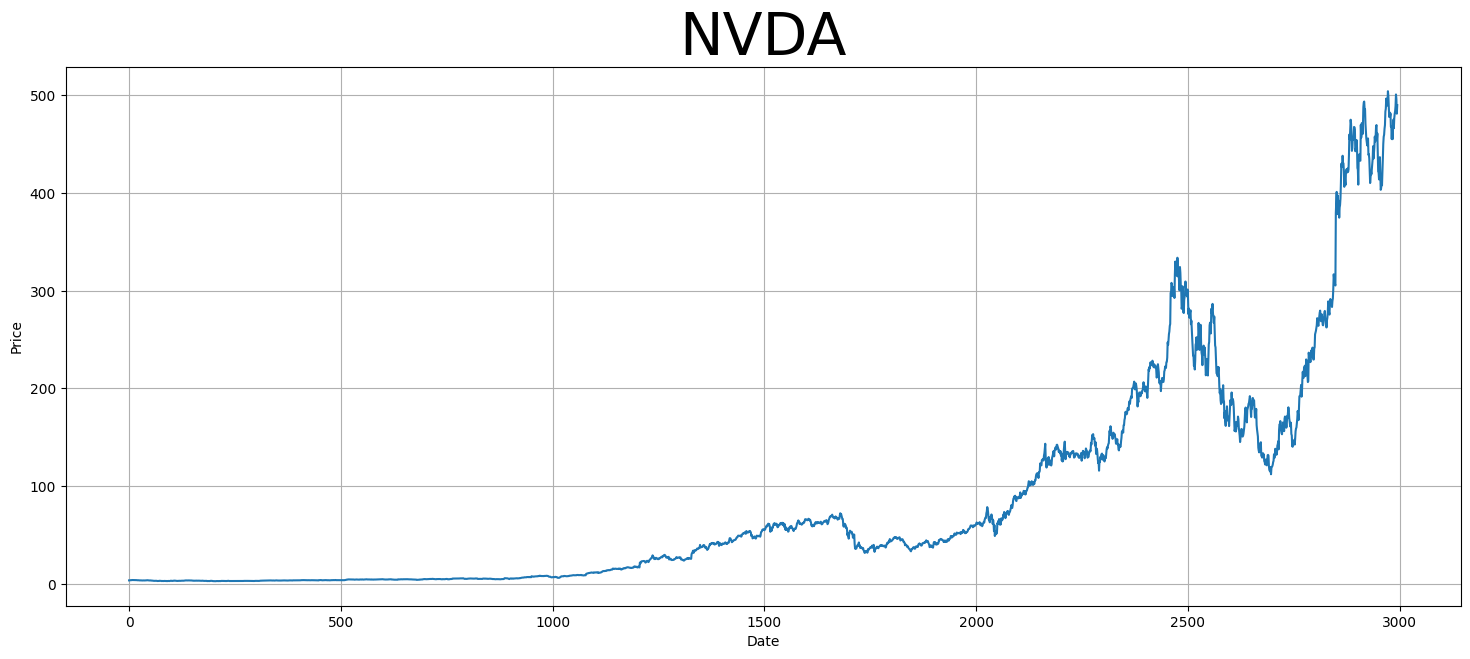

,open,high,low,close,adj close,volume
2990,481.940002,494.040009,481.200012,488.899994,488.877075,47947800
2991,494.000000,504.329987,491.500000,500.769989,500.746490,41258700
2992,494.239990,497.000000,488.950012,496.040009,496.016754,46444400
2993,496.549988,499.989990,480.980011,481.109985,481.087402,39789400
2994,488.109985,490.950012,484.190002,489.899994,489.877014,30042500


In [135]:
# Define the symbol and the date range based on your instruction to limit the analysis to the given range
symb = "NVDA"
start_date = "2012-01-30"
end_date = "2023-12-22"
df = yf.download(symb, start=start_date, end=end_date, interval="1d")

plt.figure(figsize=(18,7))
df.dropna(inplace=True)
df = df.reset_index(drop=True)
plt.plot(df['Close'] )
plt.title(symb,size=42)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()
df.columns = df.columns.str.lower()



next=df.copy()
next.tail()

In [136]:
tfig = go.Figure()
tfig.add_trace(go.Candlestick(
    x=df.index, 
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='market data'
))

tfig.update_layout(
    title='NSE live share price evolution',
    yaxis_title='Stock Price (in $)'
)

tfig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label='15m', step='minute', stepmode='backward'),
            dict(count=45, label='45m', step='minute', stepmode='backward'),
            dict(count=1, label='HTD', step='hour', stepmode='todate'),
            dict(count=2, label='2h', step='hour', stepmode='backward'),
            dict(step='all')
        ])
    )
)

tfig.show()


# Feature Engineering

In [137]:
df['future_returns'] = df['close'].pct_change().shift(-1)
signal=[]
for i in range(len(df)):
    if (df['future_returns'][i]  > 0):
        signal.append(1)
    elif (df['future_returns'][i] < 0):
        signal.append(2)
    else:
        signal.append(3)


df['signal']=signal
df['rsi'] = ta.RSI(df['close'].values, timeperiod=int(14))
df['adx'] = ta.ADX(df['high'].values, df['low'].values,df['open'].values, timeperiod=int(50))
df['NATR'] = ta.NATR(df['high'], df['low'], df["close"], timeperiod=50)
df['pct_change5'] = df['close'].pct_change(5)
df['pct_change'] = df['close'].pct_change()
df['sma'] = ta.SMA(df['close'],timeperiod=30)
df['corr'] = df['close'].rolling(window=int(6.5*4)).corr(df['sma'])
df['Open-Close']=(df["open"]-df['close']).shift(-1)
df['Close-High']=(df["close"]-df['high']).shift(-1)
df['Close-Low']=(df["close"]-df['low']).shift(-1)
"""


# Technical Indicators
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['upper_band'], df['middle_band'], df['lower_band'] = ta.BBANDS(df['close'], timeperiod=20)
df['momentum'] = df['close'] - df['close'].shift(4)
df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowd_period=3)"""

df

,open,high,low,close,adj close,volume,future_returns,signal,rsi,adx,NATR,pct_change5,pct_change,sma,corr,Open-Close,Close-High,Close-Low
0,3.662500,3.717500,3.607500,3.700000,3.394018,39907600,-0.002027,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017500,-0.020000,0.065000
1,3.710000,3.712500,3.627500,3.692500,3.387139,35790000,0.010833,1,NaN,NaN,NaN,NaN,-0.002027,NaN,NaN,0.002500,-0.042500,0.050000
2,3.735000,3.775000,3.682500,3.732500,3.423830,42802000,0.037508,1,NaN,NaN,NaN,NaN,0.010833,NaN,NaN,-0.120000,-0.015000,0.157500
3,3.752500,3.887500,3.715000,3.872500,3.552253,69623600,0.021304,1,NaN,NaN,NaN,NaN,0.037508,NaN,NaN,-0.025000,-0.032500,0.032500
4,3.930000,3.987500,3.922500,3.955000,3.627930,49523200,-0.007585,2,NaN,NaN,NaN,NaN,0.021304,NaN,NaN,0.010000,-0.015000,0.035000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,481.940002,494.040009,481.200012,488.899994,488.877075,47947800,0.024279,1,58.756538,13.887870,2.987502,0.029133,0.011169,476.796000,-0.346334,-6.769989,-3.559998,9.269989
2991,494.000000,504.329987,491.500000,500.769989,500.746490,41258700,-0.009445,2,63.156322,13.890647,2.919979,0.073991,0.024279,478.486667,-0.262720,-1.800018,-0.959991,7.089996
2992,494.239990,497.000000,488.950012,496.040009,496.016754,46444400,-0.030098,2,60.391632,13.876759,2.936524,0.040854,-0.009445,479.771000,-0.158943,15.440002,-18.880005,0.129974
2993,496.549988,499.989990,480.980011,481.109985,481.087402,39789400,0.018270,1,52.569120,13.811759,3.046124,0.000478,-0.030098,480.489667,-0.134627,-1.790009,-1.050018,5.709991


In [138]:
df['future_returns'] = df['close'].pct_change().shift(-1)
signal=[]
for i in range(len(df)):
    if (df['future_returns'][i]  > 0):
        signal.append(1)
    elif (df['future_returns'][i] < 0):
        signal.append(2)
    else:
        signal.append(3)


df['signal']=signal
#df['rsi'] = ta.RSI(df['close'].values, timeperiod=int(14))
df['adx'] = ta.ADX(df['high'].values, df['low'].values,df['open'].values, timeperiod=int(50))
df['NATR'] = ta.NATR(df['high'], df['low'], df["close"], timeperiod=50)
df['pct_change5'] = df['close'].pct_change(5)
df['pct_change'] = df['close'].pct_change()
df['sma'] = ta.SMA(df['close'],timeperiod=30)
df['corr'] = df['close'].rolling(window=int(6.5*4)).corr(df['sma'])
df['Open-Close']=(df["open"]-df['close']).shift(-1)
df['Close-High']=(df["close"]-df['high']).shift(-1)
df['Close-Low']=(df["close"]-df['low']).shift(-1)
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)


# Calculate the log high/low and log close/open
log_hl = np.log(df['high'] / df['low']) ** 2
log_co = np.log(df['close'] / df['open']) ** 2

#Adding some Additional Feature engineeering techniques
# Rolling Windows
df['rolling_mean'] = df['close'].rolling(window=20).mean()
df['rolling_std'] = df['close'].rolling(window=20).std()
df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()

# Statistical Features
df['rate_of_change'] = df['close'].pct_change().fillna(0)
df['z_score'] = (df['close'] - df['rolling_mean']) / df['rolling_std']

# Feature Interaction
df['close_volume_interaction'] = df['close'] * df['volume']


## Technical Indicators
#df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
#df['upper_band'], df['middle_band'], df['lower_band'] = ta.BBANDS(df['close'], timeperiod=20)
#df['momentum'] = df['close'] - df['close'].shift(4)
#df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowd_period=3)




df

,open,high,low,close,adj close,volume,future_returns,signal,rsi,adx,...,Close-Low,macd,macdsignal,macdhist,rolling_mean,rolling_std,ema50,rate_of_change,z_score,close_volume_interaction
0,3.662500,3.717500,3.607500,3.700000,3.394018,39907600,-0.002027,2,NaN,NaN,...,0.065000,NaN,NaN,NaN,NaN,NaN,3.700000,0.000000,NaN,1.476581e+08
1,3.710000,3.712500,3.627500,3.692500,3.387139,35790000,0.010833,1,NaN,NaN,...,0.050000,NaN,NaN,NaN,NaN,NaN,3.699706,-0.002027,NaN,1.321546e+08
2,3.735000,3.775000,3.682500,3.732500,3.423830,42802000,0.037508,1,NaN,NaN,...,0.157500,NaN,NaN,NaN,NaN,NaN,3.700992,0.010833,NaN,1.597585e+08
3,3.752500,3.887500,3.715000,3.872500,3.552253,69623600,0.021304,1,NaN,NaN,...,0.032500,NaN,NaN,NaN,NaN,NaN,3.707718,0.037508,NaN,2.696174e+08
4,3.930000,3.987500,3.922500,3.955000,3.627930,49523200,-0.007585,2,NaN,NaN,...,0.035000,NaN,NaN,NaN,NaN,NaN,3.717415,0.021304,NaN,1.958643e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,481.940002,494.040009,481.200012,488.899994,488.877075,47947800,0.024279,1,58.756538,13.887870,...,9.269989,4.474919,4.055263,0.419656,477.587001,13.267632,463.957137,0.011169,0.852676,2.344168e+10
2991,494.000000,504.329987,491.500000,500.769989,500.746490,41258700,-0.009445,2,63.156322,13.890647,...,7.089996,6.093908,4.462992,1.630916,477.976500,13.845089,465.400778,0.024279,1.646323,2.066112e+10
2992,494.239990,497.000000,488.950012,496.040009,496.016754,46444400,-0.030098,2,60.391632,13.876759,...,0.129974,6.915581,4.953509,1.962071,477.574001,13.145299,466.602317,-0.009445,1.404761,2.303828e+10
2993,496.549988,499.989990,480.980011,481.109985,481.087402,39789400,0.018270,1,52.569120,13.811759,...,5.709991,6.289532,5.220714,1.068818,476.657500,12.141188,467.171245,-0.030098,0.366726,1.914308e+10


In [139]:

df.dropna(inplace=True)

y = df[['signal']].copy()
print(y)
exclude_columns = ['date', 'close', 'open', 'high', 'low', 'volume', 'signal']  # Add any other columns you want to exclude from X
X = df[df.columns.difference(exclude_columns)]
print(X)

      signal
99         2
100        1
101        2
102        1
103        1
...      ...
2989       1
2990       1
2991       2
2992       2
2993       1

[2895 rows x 1 columns]
      Close-High  Close-Low      NATR  Open-Close   adj close        adx  \
99     -0.150000   0.007500  3.386576    0.150000    3.084428  16.985804   
100    -0.037500   0.045000  3.576204    0.000000    2.944540  16.698290   
101    -0.115000   0.012500  3.512315    0.105000    2.981232  16.416527   
102    -0.022500   0.062500  3.635178   -0.017500    2.887209  16.192462   
103    -0.022500   0.100000  3.576713   -0.100000    2.919314  15.983894   
...          ...        ...       ...         ...         ...        ...   
2989   -5.140015   7.699982  3.028322   -6.959991  483.477325  13.937461   
2990   -3.559998   9.269989  2.987502   -6.769989  488.877075  13.887870   
2991   -0.959991   7.089996  2.919979   -1.800018  500.746490  13.890647   
2992  -18.880005   0.129974  2.936524   15.440002  496.0167

# Correlation Check

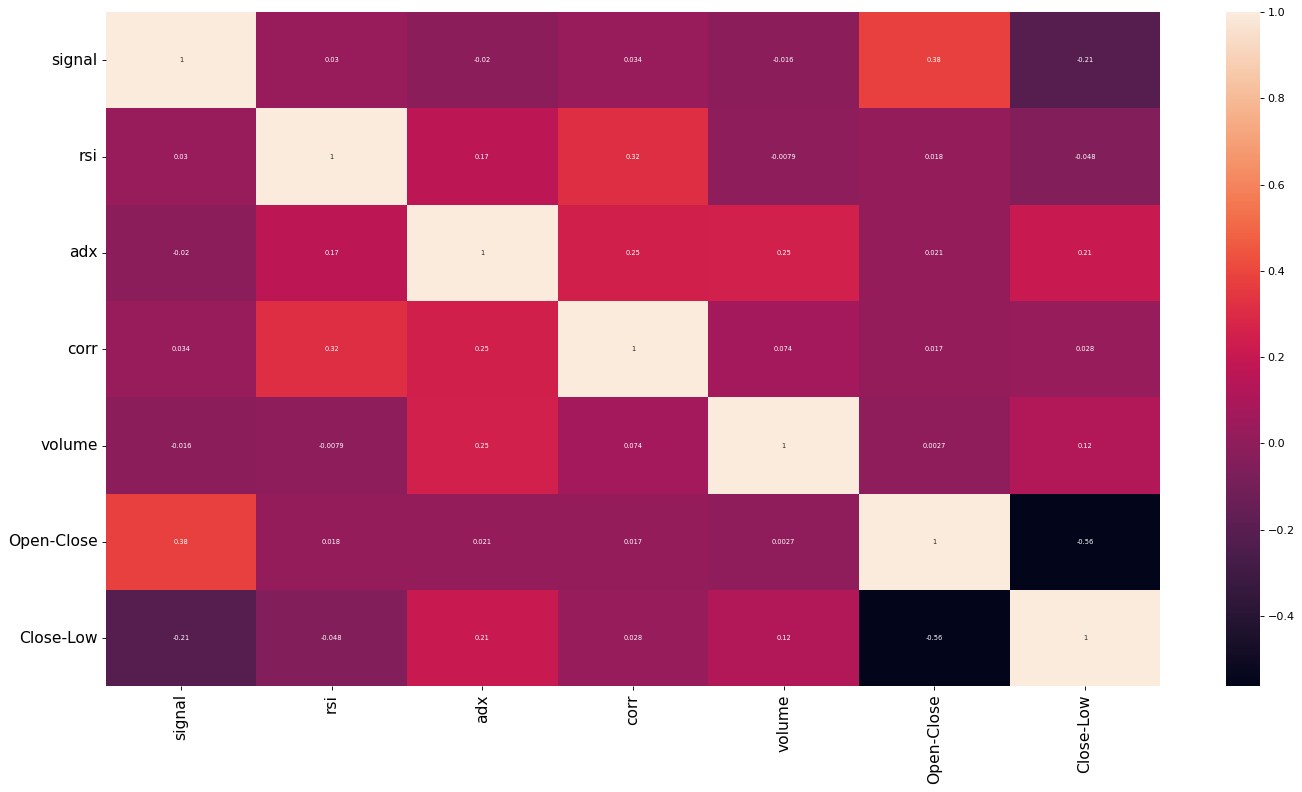

In [140]:
z=df[['signal', 'rsi','adx', 'corr','volume','Open-Close','Close-Low']].copy()
corr = z.corr()
figure(figsize=(18, 10), dpi=80)
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14); 
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [141]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
   
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))


MultiIndex([(              'pct_change',           'rate_of_change'),
            (            'rolling_mean',                      'sma'),
            (                   'ema50',                      'sma'),
            (                   'ema50',             'rolling_mean'),
            (               'adj close',             'rolling_mean'),
            (               'adj close',                      'sma'),
            (               'adj close',                    'ema50'),
            (                    'macd',               'macdsignal'),
            (               'adj close', 'close_volume_interaction'),
            ('close_volume_interaction',             'rolling_mean'),
            ('close_volume_interaction',                      'sma'),
            ('close_volume_interaction',                    'ema50'),
            (                     'rsi',                  'z_score'),
            (               'adj close',              'rolling_std'),
            (       

# Stationary Check

In [142]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    status = stationary(df[col])
    if status == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

Close-High is not stationary. Dropping it.
Close-Low is not stationary. Dropping it.
NATR is stationary.
Open-Close is stationary.
adj close is not stationary. Dropping it.
adx is stationary.
close_volume_interaction is not stationary. Dropping it.
corr is stationary.
ema50 is not stationary. Dropping it.
future_returns is stationary.
macd is stationary.
macdhist is stationary.
macdsignal is stationary.
pct_change is stationary.
pct_change5 is stationary.
rate_of_change is stationary.
rolling_mean is not stationary. Dropping it.
rolling_std is not stationary. Dropping it.
rsi is stationary.
sma is not stationary. Dropping it.
z_score is stationary.


# Splitting and Training Model

In [143]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
    return model

In [144]:
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(128,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
    return model

In [145]:
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(54, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(128,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
    return model

In [146]:
split_percentage = 0.8
split = int(split_percentage*len(df))


# Train data set
X_train = X[:split]
y_train = y[:split]
X_test =  X[split:]
y_test =  y[split:]


In [147]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2316, 13)
(2316, 1)
(579, 13)
(579, 1)


In [148]:
# Reshape input to be 3D [samples, timesteps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = create_gru_model(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=2, shuffle=False)


Epoch 1/100
73/73 - 7s - loss: 0.8895 - accuracy: 0.2422 - val_loss: 0.3470 - val_accuracy: 0.5233 - 7s/epoch - 91ms/step
Epoch 2/100
73/73 - 0s - loss: 0.3660 - accuracy: 0.5276 - val_loss: 0.2817 - val_accuracy: 0.5199 - 428ms/epoch - 6ms/step
Epoch 3/100
73/73 - 0s - loss: 0.3197 - accuracy: 0.5289 - val_loss: 0.2807 - val_accuracy: 0.5233 - 437ms/epoch - 6ms/step
Epoch 4/100
73/73 - 1s - loss: 0.3134 - accuracy: 0.5246 - val_loss: 0.2586 - val_accuracy: 0.5216 - 713ms/epoch - 10ms/step
Epoch 5/100
73/73 - 1s - loss: 0.3070 - accuracy: 0.5281 - val_loss: 0.2686 - val_accuracy: 0.5233 - 643ms/epoch - 9ms/step
Epoch 6/100
73/73 - 0s - loss: 0.3066 - accuracy: 0.5307 - val_loss: 0.2518 - val_accuracy: 0.5233 - 403ms/epoch - 6ms/step
Epoch 7/100
73/73 - 1s - loss: 0.2939 - accuracy: 0.5311 - val_loss: 0.2402 - val_accuracy: 0.5233 - 563ms/epoch - 8ms/step
Epoch 8/100
73/73 - 0s - loss: 0.2912 - accuracy: 0.5315 - val_loss: 0.2348 - val_accuracy: 0.5233 - 441ms/epoch - 6ms/step
Epoch 9/1

In [149]:
# Evaluate the model on the test set
y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int)
Accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {Accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

19/19 [==============================] - 1s 2ms/step
Accuracy: 0.5233
F1-Score: 0.3596
RMSE: 0.6942


# confusion Matrix

In [150]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           1       0.52      1.00      0.69       303
           2       0.00      0.00      0.00       275
           3       0.00      0.00      0.00         1

    accuracy                           0.52       579
   macro avg       0.17      0.33      0.23       579
weighted avg       0.27      0.52      0.36       579



# Making Latest Prediciton

In [151]:
split_percentage = 0.8
split = int(split_percentage*len(df))
temp=pd.DataFrame()
temp['close'] = df.close.iloc[split:]
temp['signal']=np.array(y_pred)
temp.tail()

,close,signal
2989,483.500000,1
2990,488.899994,1
2991,500.769989,1
2992,496.040009,1
2993,481.109985,1


In [152]:
# Variable Required for decision making
buy=[]
sell=[]
profit=[]
Close_profit=[]
Stop_loss=[]
Close_order_buy=[]
Close_order_sell=[]
position_Buy=None
position_Sell=None
profit=0.4
lose=0.4

# Decision Making Process

In [153]:
for i in range(len(temp)):
   #####################################################################################################
    if position_Buy!="Buy"  and position_Sell!="Sell" and Accuracy >0.50 and temp['signal'].iloc[i]== 1 :                          #Buy Position
                    buy.append(temp['close'].iloc[i])
                    sell.append(np.nan)
                    Close_profit.append(np.nan)
                    Stop_loss.append(np.nan)
                    Close_order_buy.append(temp['close'].iloc[i])
                    position_Buy="Buy"
    #############################################################################################
    elif  position_Sell!="Sell"  and position_Buy!="Buy" and Accuracy >0.50 and temp['signal'].iloc[i]== 2   :                     #Sell Position        
                sell.append(temp['close'].iloc[i])              
                buy.append(np.nan)
                Close_profit.append(np.nan)
                Stop_loss.append(np.nan)
                Close_order_sell.append(temp['close'].iloc[i])
                position_Sell="Sell"
        
    #################################################################################################
    elif position_Sell=="Sell" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_sell[-1]+lose) <= temp['close'].iloc[i]):                   #Take Profit Condition
            Close_profit.append(np.nan)                                        #append to take profit
            Stop_loss.append(temp['close'].iloc[i])
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        elif ((Close_order_sell[-1]-(profit)) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(temp['close'].iloc[i])
            Stop_loss.append(np.nan)                                                #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
    ########################################################################################################
    elif position_Buy=="Buy" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_buy[-1]+profit) <= temp['close'].iloc[i]):                  #Take Profit Condition
            Close_profit.append(temp['close'].iloc[i])                          #append to take profit
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None
           
        elif ((Close_order_buy[-1]-lose) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(np.nan)
            Stop_loss.append(temp['close'].iloc[i])                                  #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            df['future_returns'] = df['close'].pct_change().shift(-1)
            position_Buy=None
     
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
#################################################################
    else:
            buy.append(np.nan)
            sell.append(np.nan)
            Stop_loss.append(np.nan)
            Close_profit.append(np.nan)
temp['buy']=buy
temp['sell']=sell
temp['Close_profit']=Close_profit
temp['Stop_loss']=Stop_loss
print((temp[temp['buy']!=np.nan]).count())
print(f"Profitibily { temp['Close_profit'].count()/(temp['Close_profit'].count()+temp['Stop_loss'].count())}")

close           579
signal          579
buy             285
sell              0
Close_profit    150
Stop_loss       135
dtype: int64
Profitibily 0.5263157894736842


# Plotting

In [154]:

trace1=go.Scatter(
    y=temp.close,
    mode='lines',
    name='Close_price'
)

trace4=go.Scatter(
   
    y=temp['buy'],
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='triangle-up' ),
    name='buy'
    )
trace5=go.Scatter(
    
    y=temp.sell,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='triangle-down'),
    name='sell')
trace6=go.Scatter(
    
    y=temp.Close_profit,
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='cross'),
    name='Profit')
trace7=go.Scatter(
    
    y=temp.Stop_loss,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='cross'),
    name='Loss')

data=[trace1,trace4,trace5,trace6,trace7]
layout=go.Layout(
    title="NSE_ANN",
    yaxis=dict(title='Assest value'),
    xaxis=dict(title='Time And date'))


figure=go.Figure(data=data,layout=layout)
figure.update_layout(xaxis_rangeslider_visible=False)
pox.plot(figure)

'temp-plot.html'